In [26]:
import numpy as np
import math
from numpy.linalg import multi_dot
import scipy.stats as st
import json

In [27]:
# # first, define our problem size
# n = 10
# alpha = np.random.random((n, 1))
# k = np.random.random((n, n))
# sigma = np.array([[k[i][i]] for i in range(n)])

# # TODO: figure out how to stitch together the r_opt values with the actual stock names
# stock_names = [f'stock_{i}' for i in range(n)]

# # TODO? figure out how to generate the confidence intervals of how much money you expect to make from this

# # TODO, pick one stock to be the baseline (stock_0). Figure out some way of comparing
# # stock_0's expected performance compared to our optimal solver

# # Katrina's draft:

# max_num_stocks = 5

# # DRAFT END

# # goal, generate some vector r such that:
# # sum(r) = 1.0
# # r represents our optimal investment portfolio

In [57]:

max_num_stocks = 5
investment_window_days = 60

In [58]:
# load the data
json_data = json.loads(open('tmp.txt', 'r').read())
covariance_matrix = np.array(json_data['covariance_matrix'])
mean_vector = np.array(json_data['mean_vector'])
ticker_to_index = json_data['ticker_to_index']

index_to_ticker = {v: k for k, v in ticker_to_index.items()}

In [59]:
# alpha is the mean
# sigma is the variance along the diagonal
# k is the covariance matrix

alpha = mean_vector * investment_window_days
sigma = np.diag(covariance_matrix) * investment_window_days
k = covariance_matrix * investment_window_days

In [60]:
# element-wise math

# square every term in alpha
alpha_element_squared = alpha * alpha
sigma_element_squared = sigma * sigma

# the 3.9 formula from
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf
alpha / (alpha_element_squared + sigma_element_squared)


array([  4.04147913,  -3.74913545,  24.69965631,   5.22650904,
        19.95391186,  13.01341499,   3.84537421,   5.86376615,
         5.56765045,   3.71343986, -52.82293554,  -9.07149088,
        24.60704621,  22.00296566,  31.67555167,  20.10088876,
       -31.86221027, -37.40320664,  19.12520848,  17.28677279,
       -86.60237258, -65.05785157,   3.10683667,   4.81562946,
        -6.22947157, -32.39306832,  15.80204172, -24.95209667,
        16.28103874,   3.68867717, -83.90651125, -27.26108674,
        26.37702706,   7.92639821,  14.47388851,  13.09220121,
        11.99942312, -26.52960418,   7.66455584,  34.98664803,
        -5.51463342,  -8.40289668,   8.5591954 , -24.74657064,
         8.09526135, -35.39258287,  -6.74954321,  12.13115986,
        21.74931052,  36.00965797,   6.27038577, -29.391159  ,
        12.11437141,  -6.78689462, -21.81231857,  48.74442694,
         5.95198509, -20.20862591,  14.14739286, -11.58974298,
        -8.32181596,   3.74479985,   3.19922769,  26.71

In [61]:
# invert matrices
k_inv = np.linalg.inv(k)

# formula 3.10 from 
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf
r_opt = np.dot(k_inv, alpha)


In [62]:
# hints that I'm not sure how they all go together

# from formula 3.11
# you know that if \lambda >= \alpha_i, then we can ignore that term

# Maybe if you sort all fo the \alpha_i terms, you can see if a solution for lambda exists where all of the smaller
# values are ignored, and all of the larger values are effected by \lambda

# if you look at each term in the sum of 3.12, they are piecewise linear wrt. \lambda


In [63]:
# idea one to solve this: use line search
# main idea: function 3.12 is monotically decreasing
# so if we pick upper/lower bounds of lambda, we can just do a line search and call it a day
# monotonically decreasing means the derivative of the function wrt lambda is <= 0 across all values of lambda

# upper bound, we know that if lambda causes all of the terms to be zero, we went too far.
# i.e., alpha_i - upper_bound_lambda <= 0 \forall i
upper_bound_lambda = np.max(alpha)

# lower bound, we know that each term in the sum is >= 0 and <= the total sum term.
# so just find the lower bound of each term and take the maximum out of all of these terms
# for each term, lambda = alpha_i - alpha_i^2 - sigma_i^2
# I know this because I can do high-school algebra in my head... work it out on paper if you can't
lower_bound_lambda = np.min(alpha - (alpha_element_squared + sigma_element_squared))
# # # TODO, think about cases where there are zero values in r_opt
# # r_opt_top_stocks = r_opt[np.argsort(-r_opt)[:max_num_stocks]]
# # r_opt_top_stocks /= np.sum(r_opt_top_stocks)

# r_opt_top_stocks = [r_opt_with_names[best_stock_index][0] for best_stock_index in best_stock_indices]
# r_opt_top_stocks = np.array(r_opt_top_stocks_with_names) / np.sum(r_opt_top_stocks_with_names)
# r_opt_top_stocks

# r_opt_top_stocks_with_names = [r_opt_with_names[best_stock_index] for best_stock_index in best_stock_indices]
# r_opt_top_stocks_with_namespha - alpha_element_squared - sigma_element_squared)

print(lower_bound_lambda, upper_bound_lambda)

# now line search/binary search... first we need to evaluate the value of the 3.12 summation expression
def eval_expression(lambda_value):
    # subtract one so I can get something like \sum - 1 = 0 to solve.
    fractional_terms = (alpha - lambda_value) / (alpha_element_squared + sigma_element_squared)
    # heavyside function
    fractional_terms = np.maximum(fractional_terms, 0)
    return np.sum(fractional_terms) - 1

# sanity check, the correct value (0) is between the upper bound and lower bound
eval_expression(lower_bound_lambda), eval_expression(upper_bound_lambda)

# there's a tolerance term usually, more on that later
tolerance = 1e-9

# initialize our loop with our initial guess
lower_lambda = lower_bound_lambda
upper_lambda = upper_bound_lambda
middle_lambda = (lower_bound_lambda + upper_bound_lambda) / 2

iterations = 0
while np.abs(eval_expression(middle_lambda)) > tolerance:
    middle_value = eval_expression(middle_lambda)
    if middle_value > 0:
        lower_lambda = middle_lambda
    else:
        upper_lambda = middle_lambda
    middle_lambda = (lower_lambda + upper_lambda) / 2

    iterations += 1
    print(f'iteration: {iterations}, {middle_lambda}, {eval_expression(middle_lambda)}')


-0.365161484814877 0.706324245755154
iteration: 1, 0.4384528131126462, -0.4851584449146573
iteration: 2, 0.3045170967913924, 2.4144009186886874
iteration: 3, 0.3714849549520193, -0.2635192267667682
iteration: 4, 0.33800102587170583, 0.31824602459833384
iteration: 5, 0.3547429904118625, -0.10673790449142584
iteration: 6, 0.34637200814178415, 0.031375066080680414
iteration: 7, 0.35055749927682334, -0.03768141920537271
iteration: 8, 0.34846475370930374, -0.0031531765623462604
iteration: 9, 0.34741838092554395, 0.014110944759166966
iteration: 10, 0.34794156731742387, 0.0054788840984099085
iteration: 11, 0.3482031605133638, 0.001162853768031935
iteration: 12, 0.34833395711133375, -0.0009951613971566076
iteration: 13, 0.34826855881234875, 8.384618543799682e-05
iteration: 14, 0.34830125796184125, -0.00045565760585919435
iteration: 15, 0.348284908387095, -0.00018590571021104285
iteration: 16, 0.3482767335997219, -5.1029762386578525e-05
iteration: 17, 0.3482726462060353, 1.640821152570915e-05
i

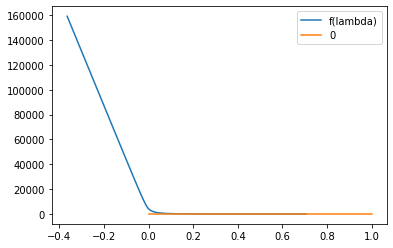

In [64]:
import matplotlib.pyplot as plt

x = np.linspace(lower_bound_lambda, upper_bound_lambda, 101)
plt.plot(x, [eval_expression(el) for el in x], label='f(lambda)')
plt.plot([0, 1], [0, 0], label='0')
plt.legend()

plt.show()


In [65]:
# get the optimal investment portfolio
r_opt = np.maximum(0, (alpha - middle_lambda) / (alpha_element_squared + sigma_element_squared))
r_opt = r_opt.flatten()

# r_opt_with_names = list(zip(r_opt, stock_names))
best_stock_indices = np.argsort(-r_opt)[:max_num_stocks]
best_stock_prices = r_opt[best_stock_indices]
best_stock_prices /= np.sum(best_stock_prices)

r_opt_top_stocks_with_names = []
for best_stock_price, best_stock_index in zip(best_stock_prices, best_stock_indices):
    r_opt_top_stocks_with_names.append([best_stock_price, index_to_ticker[best_stock_index]])
r_opt_top_stocks_with_names


[[0.6881634542865412, 'MRNA'],
 [0.24875930216093575, 'PAYC'],
 [0.063077243552523, 'FTNT'],
 [0.0, 'A'],
 [0.0, 'NWS']]

In [66]:
expected_val = np.dot(r_opt, alpha)


In [67]:
# brief lecture on probabilities (mean/variance)
# E[X]=mean(X), Var[X]=Variance(X)
# let a be a constant
# Var[X] = E[X^2] - E[X]^2
# aE[X] = E[aX]
# a^2Var[X] = Var[(aX)]
# Let v be some vector, K be the covariance matrix
# Var(Kv) = v^t K v

# we now have r_opt, find the mean and variance of investing in r_opt
# alpha, sigma

# Amber and Katrina's draft:

expected_val = np.dot(r_opt, alpha)

print("Mean/expected total return: ", expected_val)

# TODO: find the variance with weighted variables formula that includes r_opt values (Attempted/done 9/3/21)

# http://www.math.kent.edu/~reichel/courses/monte.carlo/alt4.7d.pdf

# (r_opt^T * covariance_matrix * r_opt)

# T is transpose. Matrix product operation (dot product)

# variance = sum((expected_return_array[i] - expected_val)**2 for i in range(len(expected_return_array) - 1)) / len(expected_return_array)

variance = multi_dot([r_opt.T, covariance_matrix, r_opt])

standard_dev = np.sqrt(variance)

print("Variance: ", variance)
print("Standard dev: ", standard_dev, "\n")

# Calculating confidence intervals:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
for confidence_level in [0.99, 0.95, 0.85]:
    error = abs(st.norm.ppf((1-confidence_level)/2)) * standard_dev
    print(f"{confidence_level * 100}% confidence interval: {expected_val}", u"\u00B1", error)


Mean/expected total return:  0.6043943063161932
Variance:  0.0012187938200147572
Standard dev:  0.03491122770706807 

99.0% confidence interval: 0.6043943063161932 ± 0.08992536335073421
95.0% confidence interval: 0.6043943063161932 ± 0.06842474896193027
85.0% confidence interval: 0.6043943063161932 ± 0.05025581097342306


In [68]:
np.exp(0.11676983430967593)

1.1238607257395243

In [69]:
np.argsort(-alpha)[:max_num_stocks]

array([313, 354, 192, 149, 311])

In [70]:
[index_to_ticker[el] for el in np.argsort(-alpha)[:20]]

['MRNA',
 'PAYC',
 'FTNT',
 'DXCM',
 'MPWR',
 'NOW',
 'RMD',
 'ALB',
 'GNRC',
 'BIO',
 'CMG',
 'CTLT',
 'WST',
 'MSCI',
 'NRG',
 'DHR',
 'PKI',
 'CRL',
 'NVDA',
 'REGN']

In [71]:
[alpha[el] for el in np.argsort(-alpha)[:20]]

[0.706324245755154,
 0.38532692194164625,
 0.3562951768967905,
 0.34534904507768005,
 0.34481231699922626,
 0.3397503414601219,
 0.3397479266197805,
 0.31858654567543077,
 0.315519503220881,
 0.3123973110852709,
 0.3118998894023043,
 0.30163176767259114,
 0.3002282663564738,
 0.2980000088786028,
 0.2900538492123639,
 0.2885911496955217,
 0.28541454571996155,
 0.2823727622631504,
 0.2805102550517632,
 0.2692629439845023]

In [72]:
np.exp(0.010663833857211109) * 365

368.91312674213805

In [73]:
indices = np.array([ticker_to_index[ticker] for ticker in ['ETSY']])
np.array([[covariance_matrix[i, j] for i in indices] for j in indices])
r_opt[indices]
index_variance = np.array([[covariance_matrix[i, j] for i in indices] for j in indices])
index_mean = r_opt[indices]


In [20]:
variance = multi_dot([index_mean.T, index_variance, index_mean])
variance

0.0

In [21]:
np.sqrt(variance)

0.0

In [22]:
index_variance

array([[0.00083249]])

In [23]:
index_mean

array([0.])

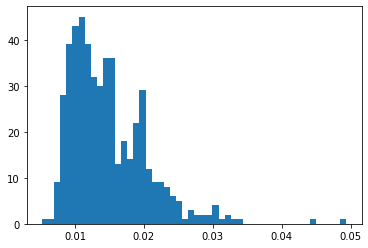

In [24]:
plt.hist(np.sqrt(np.diag(covariance_matrix)), bins=50)
plt.show()

In [25]:
np.sqrt(index_variance)

array([[0.0288529]])